# Rohit Ganti QOSF Task #2 Notebook

In [1]:
# Import libraries
from qiskit import *
import numpy as np
from qiskit.algorithms.optimizers import SLSQP, SPSA, COBYLA
from qiskit.visualization import plot_histogram
import pandas as pd

In [2]:
#setting the initial functions
n_qubits = 4
n_layers = 2
random_states = ['0000', '0001', '0010', '0011']*10000
outputs = ['0011', '0101', '1010', '1100']*10000

In [3]:
def create_circuit(init_state, params):
    """
    Function to create the quantum circuit on qiskit 
    """
    qc = QuantumCircuit(n_qubits+1, n_qubits)
    for i, bit in enumerate(reversed(init_state)): #preparing the initial state for the qubit
        if bit == '1':
            qc.x(i)
    vq_circuit = variational_circuit(n_qubits, n_layers, params) #initiating the variational ciruit to be trained
    qc.compose(vq_circuit, inplace=True) # adding the variational circuit to the main circuit
    qc.measure(range(4), range(4)) # measuring the state of the circuit
    return qc

In [4]:
def variational_circuit(n_qubits, n_layers, params):
    """
    Function to create the variational circuit
    """
    qc = QuantumCircuit(n_qubits+1, n_qubits) # quantum circuit    
    for i in range(n_layers):
        for j in range(n_qubits):
            qc.rx(params[2*n_qubits*i + 2*j], j) #parameterizing the rotation of the spin
            qc.rz(params[2*n_qubits*i + 2*j+1], j)
        for j in range(n_qubits-1): #entangling the qubits
            for k in range(j+1, n_qubits):
                qc.cx(j, k)
    for i in range(n_qubits):
        qc.rx(params[-8+2*i], i)
        qc.rz(params[-8+(2*i+1)], i)
    qc.x([0, 1])
    qc.ccx(0, 1, 4)
    qc.x([0, 1])
    qc.ccx(0, 1, 4)
    qc.cx(4, 0)
    qc.cx(4, 1)
    return qc

In [5]:
def simulate(qc):
    """
    Function to simulate the initial and the variational circuit
    """
    simulator = Aer.get_backend('qasm_simulator')
    executor = execute(qc, backend=simulator, shots=8192).result()
    return executor.get_counts(qc)

In [6]:
def objective_fn(params):
    """
    objective function to get to the number of counts to get the correct measurement and then return the correct cost
    """
    init_state_index = np.random.randint(0, 4000)
    qc = create_circuit(random_states[init_state_index], params) #the quantum circuit with the input parameters
    counts = simulate(qc) #measurement counts for the circuit
    cost = 1000
    if outputs[init_state_index] in counts.keys():
        out_counts = counts[outputs[init_state_index]]
        cost = ((9000 - out_counts)**2) / (9000**2)
    return cost

In [7]:
opt = COBYLA(maxiter=500, tol=0.000001, disp=True) #Neural network with optimizing function
num_params = 2*n_layers*n_qubits + 8 #parameters of the function
init_params = np.random.randn(num_params)
bounds = np.array([(-np.pi, np.pi)]*num_params)
min_params, min_cost, number = opt.optimize(num_vars=num_params,objective_function=objective_fn,initial_point=init_params,variable_bounds=bounds)
print("Optimized cost:", min_cost)
print("No. of calls to obj fn: ",number)

Optimized cost: 0.008628345679012345
No. of calls to obj fn:  383


### Result with the measured states

Input state: 0000
Output state:


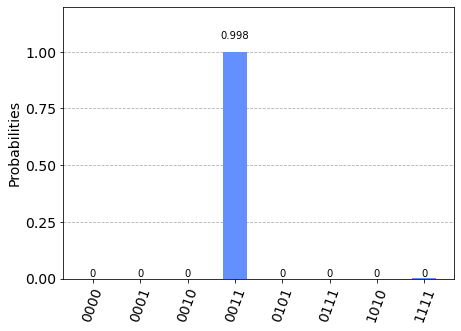

Input state: 0001
Output state:


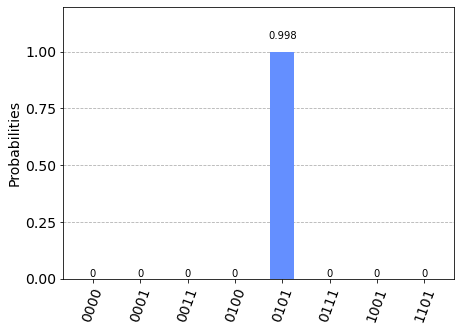

Input state: 0010
Output state:


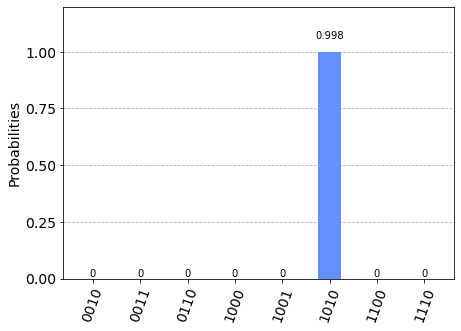

Input state: 0011
Output state:


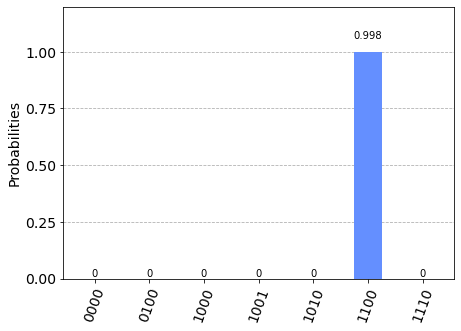

Input state: 0000
Output state:


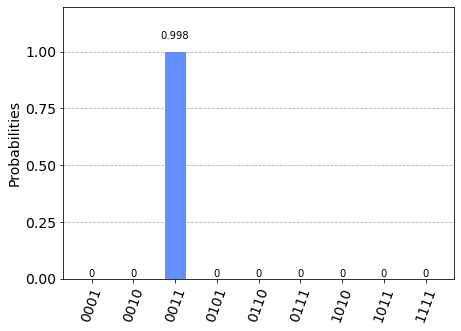

Input state: 0001
Output state:


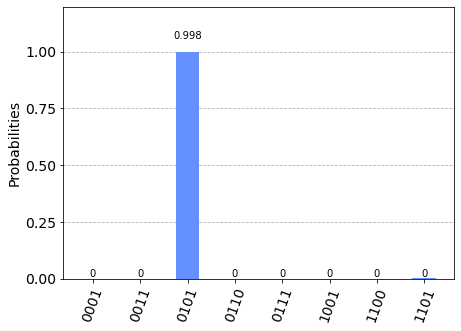

Input state: 0010
Output state:


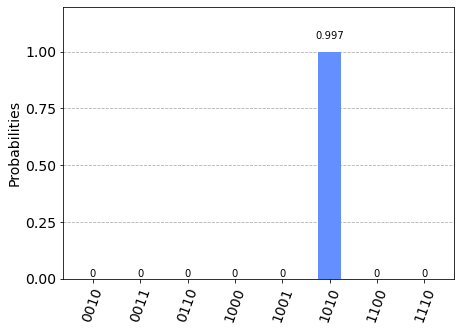

Input state: 0011
Output state:


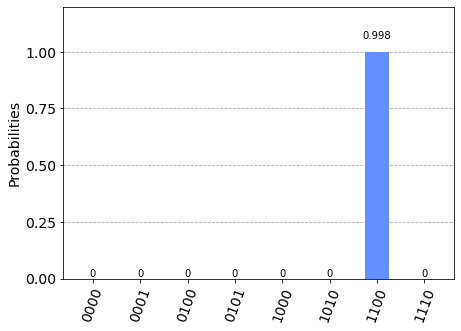

Input state: 0000
Output state:


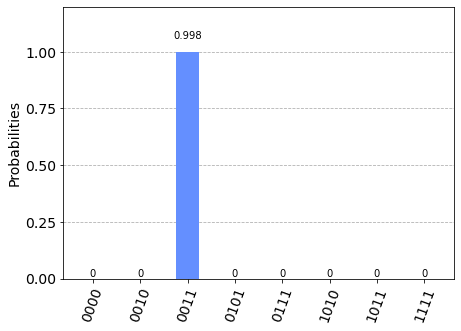

Input state: 0001
Output state:


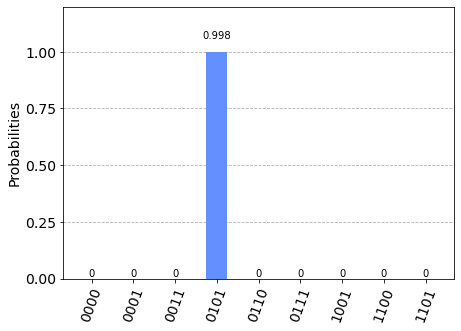

In [8]:
for i in range(10):
    print(f"Input state: {random_states[i]}")
    print(f"Output state:")
    qc_test = create_circuit(random_states[i], min_params)
    counts = simulate(qc_test)
    display(plot_histogram(counts))

### Trying with different measurements and outputs

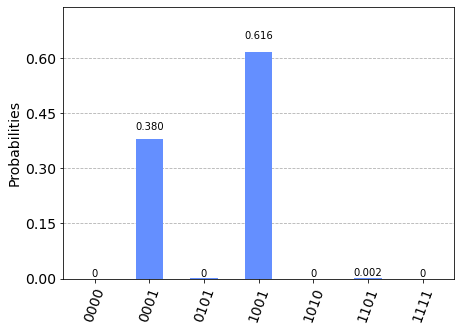

In [9]:
qc_test = create_circuit('1101', min_params)
counts = simulate(qc_test)
display(plot_histogram(counts))

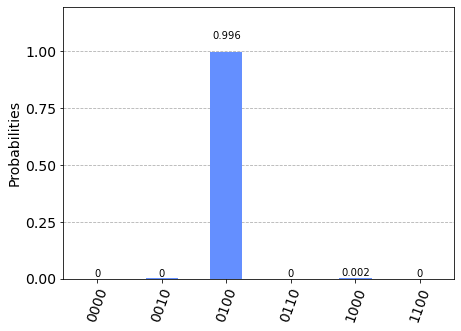

In [10]:
qc_test = create_circuit('1011', min_params)
counts = simulate(qc_test)
display(plot_histogram(counts))

# result representation of one state to another

In [11]:
#10 measurements mapping
for i in range(10):
    qc_test = create_circuit(f'{i:4b}', min_params)
    counts = simulate(qc_test)
    max_count_state = [k for k, v in counts.items() if v == max(counts.values())][0]
    print("State A: ", f'{i:04b}', " ----> State B: ",max_count_state)

State A:  0000  ----> State B:  0011
State A:  0001  ----> State B:  0101
State A:  0010  ----> State B:  1010
State A:  0011  ----> State B:  1100
State A:  0100  ----> State B:  0111
State A:  0101  ----> State B:  0001
State A:  0110  ----> State B:  1110
State A:  0111  ----> State B:  1000
State A:  1000  ----> State B:  1011
State A:  1001  ----> State B:  1101
